<a href="https://colab.research.google.com/github/ratmonger/SentimentAnalysis/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import numpy as np
import librosa
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import sklearn.naive_bayes
import sklearn.linear_model
import sklearn.svm
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from google.colab import drive
import math
from sklearn.decomposition import PCA
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import warnings

In [28]:
warnings.filterwarnings("ignore")

In [29]:
drive.mount('/content/drive')
train_path = "drive/MyDrive/LogRegression/data/train" # path that contains the audio files for training
test_path = "drive/MyDrive/LogRegression/data/test" # path that contains the audio files for testing
iris_data = pd.read_csv("drive/MyDrive/LogRegression/data/iris.csv") # read iris dataset into csv
wine_data = pd.read_csv("drive/MyDrive/LogRegression/data/wine.csv", sep = ";") # read wine dataset into csv
#mobile_data = pd.read_csv("drive/MyDrive/LogRegression/data/mobile.csv") # read mobile prices dataset into csv
train_data = pd.read_csv("drive/MyDrive/LogRegression/train6.csv") # read dataset created from training feature extraction into csv
test_data = pd.read_csv("drive/MyDrive/LogRegression/test6.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = train_data.drop(columns=train_data.columns[0])
test_data = test_data.drop(columns=test_data.columns[0])
train_data = train_data.drop(columns=train_data.columns[0])
test_data = test_data.drop(columns=test_data.columns[0])


print(train_data)


     feature0   feature1   feature2   feature3   feature4   feature5  \
0    1.513677  20.918501  49.160374  41.953712  35.630013  34.699394   
1    1.299003  10.483940  33.293514  40.552540  30.238134  27.645216   
2    5.632851  26.472286  55.377140  52.526165  33.707314  21.179777   
3    1.525546  20.959337  49.247059  41.831711  35.696522  34.437305   
4    1.464042   7.294148  17.259890  21.127213  19.707209  19.815882   
..        ...        ...        ...        ...        ...        ...   
895  2.497897   3.063264  10.590133  23.534359  31.595707  26.577105   
896  0.370338   0.597036   4.195417   9.196877   9.577950  11.166047   
897  0.891233   2.600185   9.442829  19.256107  20.903851  13.036436   
898  2.699126   2.398128   1.648577   2.771617   3.937202   5.498955   
899  3.307154   5.220232  12.010968  23.482868  29.604258  24.041502   

      feature6   feature7   feature8   feature9  ...  feature20443  \
0    26.323664  23.403133  20.283451  19.226046  ...      0.00036

In [ ]:
print(train_data.shape)

# Step 1: Calculate variance for each column
variances = train_data.iloc[:, :-1].var()

# Step 2: Determine the threshold for the bottom 10% of variances
threshold = variances.quantile(0.8)
print(threshold)


# Step 3: Identify columns with variances below the threshold
low_variance_columns = variances[variances <= threshold].index

# Step 4: Drop columns with low variance
df_filtered = train_data.drop(columns=low_variance_columns)
test_filtered = test_data.drop(columns=low_variance_columns)


print("\nDataFrame after dropping columns with low variance:")
print(df_filtered.shape)


(900, 20453)
0.3388148531896494

DataFrame after dropping columns with low variance:
(900, 4092)


In [ ]:
def standardize_vector(vector):
    # Calculate the mean and standard deviation of the vector
    mean = np.mean(vector)
    std_dev = np.std(vector)

    # Standardize each component of the vector
    standardized_vector = (vector - mean) / std_dev

    return standardized_vector

In [ ]:
# class for logistic regression
class LogisticRegression:
  def __init__(self, X, Y, tolerance = 1e-6, step = 0.01, penalty = 0.001, num_iters = 1000000):
    self.X = X # dataframe containing training data; excludes the class column
    self.X['BIAS'] = 1 # add BIAS column filled with 1's
    self.Y = Y # column from training dataframe indicating classes
    self.tolerance = tolerance # epsilon; tolerance to error during convergence to max
    self.step = step # eta; step size/learning rate
    self.penalty = penalty # lambda; penalty to avoid overfitting used in regularization
    self.num_instances, self.num_features = X.shape # shape returns (row_count, col_count); get dimensions of X: training dataframe
    self.num_classes = len(Y.unique()) # get the number of unique classes in dataset
    self.weights = np.random.uniform(-0.1, 0.1, (self.num_features, self.num_classes)) # initialize weights matrix with numbers between -0.1 and 0.1 of dimensions (features x classes)
    self.num_iters = num_iters # set the maximum number of iterations that can run during the training process (learning weights)

  # softmax converts the values of a matrix of dimension ((features + 1) x classes) such that each row sums to 1
  # X is a matrix (numpy or dataframe) of dimension ((features + 1) x classes)
  # X will be the weights matrix when training and the testing dataframe when predicting
  def softmax(self, X):
    numerator = np.dot(X, self.weights) # matrix mult between X and weights matrices in the numerator; results in (instances x classes) size matrix
    # jon note: try to scale values down so that everything is btwn [-1,1] or [0,1] -- linear scaling
    numerator -= np.max(numerator) # subtract the maximum value of matrix from each value in matrix to avoid overflow
    numerator = np.exp(numerator) # raise e^(numerator)
    denominator = np.sum(numerator, axis = 1, keepdims = True) # sum
    return numerator / denominator

  def gradient_ascent(self, X, errors):
    return np.dot(errors.T, X) / self.num_instances

  # training uses gradient ascent; end training when converge -- when error is less than tolerance
  def train(self, X, Y):
    one_hot_encoded_y = pd.get_dummies(Y)
    i = 1
    prev_error = 100000
    while True:

      Y_predicted = self.softmax(X)
      errors = Y_predicted - one_hot_encoded_y # try squaring
      curr_error = np.mean(np.mean(np.abs(errors), axis = 0)) # sum of errors in matrix

      #print(f"previous error: {prev_error}, current error: {curr_error}, diff: {np.abs(curr_error - prev_error)}, tol: {self.tolerance}, iter: {i}")
      if (np.abs(curr_error - prev_error) < self.tolerance) or (i >= self.num_iters):
        break

      gradients = self.gradient_ascent(X, errors)
      # Standardize each component of the vector

      #test_round = round(prev_error, 5)

      self.weights = self.weights - self.step * (gradients.T - self.penalty * self.weights)
      #self.weights = self.weights - (self.step * gradients.T) - (self.step * self.penalty * np.square(np.linalg.norm(self.weights)))
      #self.weights = standardize_vector(self.weights)

      i += 1
      prev_error = curr_error

  def predict(self, X):
    X['BIAS'] = 1 #add BIAS column filled with 1's
    class_probabilities = self.softmax(X) # convert features into probabilities
    return np.argmax(class_probabilities, axis = 1) # return max probabilities for each instance

In [ ]:
dataset = train_data
test = test_data

dataset = df_filtered
test = test_filtered

X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]



# change these for file naming
components = 250
count = 39 # count of predictions
version = "v6" # version of the training csv i generated
test_size = 0.01

#X_train = X
#y_train = y

'''X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 10, stratify = y)'''

X_train = X
y_train = y

# initialise the Scaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
#X_test = pd.DataFrame(scaler.transform(X_test))
test = pd.DataFrame(scaler.transform(test))



503


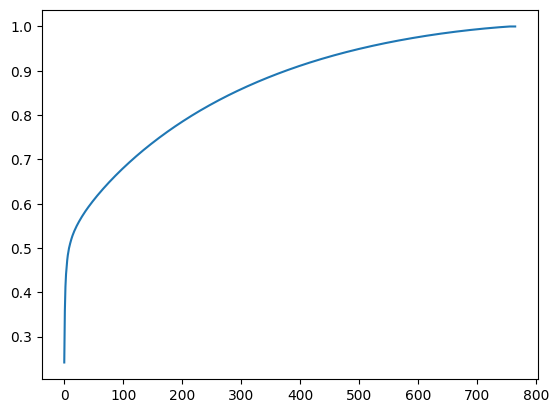

In [ ]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

pca = PCA(n_components=d)  # or pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
d

plt.plot(cumsum)
print(d)

In [ ]:
components = d

# remove first pca ?
pca = PCA(n_components = 0.79) # have to modify pca depending on dataset chosen; iris - 4, wine - 11, mobile - 20, train - 400, 450 (?)
X_train = pd.DataFrame(pca.fit_transform(X_train))
#X_test = pd.DataFrame(pca.transform(X_test))
test = pd.DataFrame(pca.transform(test))


'''# Selecting components with highest variance excluding the very first one
explained_variance = pca.explained_variance_ratio_[1:]
sorted_indices = explained_variance.argsort()[::-1]
selected_indices = sorted_indices[:components]
selected_components = pca.components_[selected_indices]

# Transforming the data using selected components
X_train = pd.DataFrame(np.dot(X_train, selected_components[:, :components].T))
X_test = pd.DataFrame(np.dot(X_test, selected_components[:, :components].T))
test = pd.DataFrame(np.dot(test, selected_components[:, :components].T))'''


# listing the hyperparameters that got the best accuracy (for me)
# iris data:  tolerance = 1e-6, step = 0.01, penalty = 0.001, num_iters = 1000000 | 100%
# wine data: tolerance = 1e-7, step = 0.01, penalty = 0.001, num_iters = 1000000  | 60.62% (not the full percentage but close enough)
# audio data: tolerance = 1e-6, step = 0.01, penalty = 0.0001, num_iters = 1000000 | 68.33333333333333% w/ 400, 450 PCA
log_reg = LogisticRegression(X_train, y_train, tolerance = 1e-6, step = 0.01, penalty = 0.0001, num_iters = 1000000)
log_reg.train(X_train, y_train)

definitions = pd.get_dummies(y_train).columns.to_numpy()
#y_pred = log_reg.predict(X_test)

reverse_factor = dict(zip(range(len(definitions)), definitions))
#y_pred = np.vectorize(reverse_factor.get)(y_pred)

'''acc = accuracy_score(y_test, y_pred)
print(np.asarray(y_test))
print(y_pred)
print(f"Accuracy: {acc * 100}%\n")'''

test_pred = log_reg.predict(test)
test_pred = np.vectorize(reverse_factor.get)(test_pred)
print(test_pred)

audios_txt = "drive/MyDrive/LogRegression/data/test/list_test.txt"
with open(audios_txt, 'r') as file:
    audio_files_list = file.readlines()
audio_files_list = [line.strip() for line in audio_files_list]

file_name = f"drive/MyDrive/LogRegression/prediction{count}_{components}pca_feats{version}_testsize{test_size}_removepca1.csv"
zipped = zip(audio_files_list, test_pred)
with open(file_name, "w", newline="") as csvfile: # CHANGE FILE NAME EVERY TEST
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["id", "class"])  # header
    csvwriter.writerows(zipped)

['hiphop' 'reggae' 'classical' 'rock' 'country' 'blues' 'blues' 'country'
 'classical' 'blues' 'jazz' 'jazz' 'blues' 'hiphop' 'hiphop' 'rock'
 'reggae' 'rock' 'blues' 'reggae' 'blues' 'disco' 'pop' 'disco' 'disco'
 'metal' 'blues' 'rock' 'hiphop' 'hiphop' 'metal' 'blues' 'country'
 'blues' 'hiphop' 'blues' 'metal' 'country' 'country' 'classical' 'metal'
 'metal' 'blues' 'metal' 'classical' 'hiphop' 'disco' 'classical' 'blues'
 'rock' 'pop' 'rock' 'jazz' 'classical' 'hiphop' 'pop' 'metal' 'metal'
 'rock' 'pop' 'blues' 'pop' 'disco' 'rock' 'pop' 'disco' 'pop' 'jazz'
 'rock' 'hiphop' 'pop' 'reggae' 'classical' 'blues' 'classical' 'reggae'
 'metal' 'reggae' 'classical' 'hiphop' 'disco' 'country' 'jazz' 'rock'
 'hiphop' 'rock' 'pop' 'classical' 'blues' 'jazz' 'jazz' 'disco' 'jazz'
 'blues' 'classical' 'metal' 'reggae' 'blues' 'country' 'disco']


In [ ]:
# idk if this is actually doing anything
def resample_audio_file(path, sampling_rate):
    y, sr = librosa.load(path)

    # resample the audio file to specified sampling rate
    y = librosa.resample(y, orig_sr = sr, target_sr = sampling_rate)

    return y, sampling_rate

In [ ]:
# method to extract features from audio files using librosa
# https://librosa.org/doc/main/feature.html
def extract_features(path, sampling_rate):
    # audio file load
    # y - time series containing audio waveform data in 1D numpy array
    # sr - audio file sampling rate (how many samples of audio captured per sec) in Hz
    y, sr = resample_audio_file(path, sampling_rate)
    y = librosa.util.normalize(y)

    # extract features -- just extracting features mentioned in rubric for now but can add more later

    # extract short-time fourier transform
    stft = librosa.stft(y = y)
    stft_mag = np.abs(stft)
    stft_phase = np.angle(stft)
    # extract mel-frequency cepstral coefficients
    # note: can change n_mfcc later; idk a good one at the moment just choosing a smaller one
    mfccs = librosa.feature.mfcc(y = y, sr = sr)
    # extract chroma feature
    chroma = librosa.feature.chroma_stft(y = y, sr = sr)
    # extract spectral contrast
    spectral_contrast = librosa.feature.spectral_contrast(y = y, sr = sr)
    # extract spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y = y, sr = sr)
    # extract spectral rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y = y, sr = sr)
    # extract temporal features: zero-crossing rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y = y)
    # extract temporal features: energy
    energy = librosa.feature.rms(y = y)
    # extract tempo
    tempo = librosa.feature.tempo(y = y, sr = sr)
    # add tempogram ratio later? also determine suitable hop length, n_fft, and win length
    tempogram_ratio = librosa.feature.tempogram_ratio(y = y, sr = sr)
    #fourier_tempogram = librosa.feature.fourier_tempogram(y = y, sr = sr)
    tonnetz = librosa.feature.tonnetz(y = y, sr = sr)
    mel_spectorgram = librosa.feature.melspectrogram(y = y, sr = sr)
    poly_features = librosa.feature.poly_features(y = y, sr = sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y = y, sr = sr)
    spectral_flatness = librosa.feature.spectral_flatness(y = y)
    chroma_cqt = librosa.feature.chroma_cqt(y = y, sr = sr)
    chroma_cens = librosa.feature.chroma_cens(y = y, sr = sr)
    #chroma_vqt = librosa.feature.chroma_vqt(y = y, sr = sr, intervals = "equals")

    # Extract harmonic and percussive components
    harmonic, percussive = librosa.effects.hpss(y)
    # Extract pitch using Melody extraction
    pitch, mag = librosa.piptrack(y=y, sr=sr)


    print(f"stft_mag: {len(np.mean(stft_mag, axis = 1))}")
    print(f"stft_phase: {len(np.mean(stft_phase, axis = 1))}")
    print(f"mfccs: {len(np.mean(mfccs, axis = 1))}")
    print(f"chroma: {len(np.mean(chroma, axis = 1))}")
    print(f"spectral_contrast: {len(np.mean(spectral_contrast, axis = 1))}")
    print(f"spectral_centroid: {len(np.mean(spectral_centroid, axis = 1))}")
    print(f"spectral_rolloff: {len(np.mean(spectral_rolloff, axis = 1))}")
    print(f"zero_crossing_rate: {len(np.mean(zero_crossing_rate, axis = 1))}")
    print(f"energy rms: {len(np.mean(energy, axis = 1))}")
    print(f"tempo: {len(tempo)}")
    print(f"tempogram ratio: {len(np.mean(tempogram_ratio, axis = 1))}")
    #print(f"fourier tempogram: {len(np.mean(fourier_tempogram, axis = 1))}")
    print(f"tonnetz: {len(np.mean(tonnetz, axis = 1))}")
    print(f"mel spectrogram: {len(np.mean(mel_spectorgram, axis = 1))}")
    print(f"poly features: {len(np.mean(poly_features, axis = 1))}")
    print(f"spectral bandwidth: {len(np.mean(spectral_bandwidth, axis = 1))}")
    print(f"spectral flatness: {len(np.mean(spectral_flatness, axis = 1))}")
    print(f"chroma cqt: {len(np.mean(chroma_cqt, axis = 1))}")
    print(f"chroma cens: {len(np.mean(chroma_cens, axis = 1))}")
    #print(f"chroma vqt: {len(np.mean(chroma_vqt, axis = 1))}")
    print("\n")

    # concat all features by taking mean of each
    features = np.concatenate([


        # std, median, max, min , IQR


        np.mean(stft_mag, axis = 1), # axis = 1 -> take mean of column instead of row
        np.var(stft_mag, axis = 1), # axis = 1 -> take mean of column instead of row

        np.mean(stft_phase, axis = 1),
        np.var(stft_phase, axis = 1),

        np.mean(mfccs, axis = 1),
        np.var(mfccs, axis = 1),

        np.mean(chroma, axis = 1),
        np.var(chroma, axis = 1),

        np.mean(spectral_contrast, axis = 1),
        np.var(spectral_contrast, axis = 1),

        np.mean(spectral_centroid, axis = 1),
        np.var(spectral_centroid, axis = 1),

        np.mean(spectral_rolloff, axis = 1),
        np.var(spectral_rolloff, axis = 1),

        np.mean(zero_crossing_rate, axis = 1),
        np.var(zero_crossing_rate, axis = 1),

        np.mean(energy, axis = 1),
        np.var(energy, axis = 1),

        tempo,

        np.mean(tempogram_ratio, axis = 1),
        np.var(tempogram_ratio, axis = 1),

        #np.mean(fourier_tempogram, axis = 1),
        np.mean(tonnetz, axis = 1),
        np.var(tonnetz, axis = 1),

        np.mean(mel_spectorgram, axis = 1),
        np.var(mel_spectorgram, axis = 1),

        np.mean(poly_features, axis = 1),
        np.var(poly_features, axis = 1),

        np.mean(spectral_bandwidth, axis = 1),
        np.var(spectral_bandwidth, axis = 1),

        np.mean(spectral_flatness, axis = 1),
        np.var(spectral_flatness, axis = 1),

        np.mean(chroma_cqt, axis = 1),
        np.var(chroma_cqt, axis = 1),

        np.mean(chroma_cens, axis = 1),
        np.var(chroma_cens, axis = 1)

    ])

    print(features.shape)

    return features

In [ ]:
# list comprehension to iterate through audio files and extract features
# 44,100 Hz is common consumer audio sampling rate
extracted_features = [
    np.append(np.append([audio_file], extract_features(os.path.join(train_path, genre_dir, audio_file), 44100)), [genre_dir])
    for genre_dir in os.listdir(train_path)
    if os.path.isdir(os.path.join(train_path, genre_dir))
    for audio_file in os.listdir(os.path.join(train_path, genre_dir))
    if audio_file.endswith('.au')
]

stft_mag: 1025
stft_phase: 1025
mfccs: 20
chroma: 12
spectral_contrast: 7
spectral_centroid: 1
spectral_rolloff: 1
zero_crossing_rate: 1
energy rms: 1
tempo: 1
tempogram ratio: 13
tonnetz: 6
mel spectrogram: 128
poly features: 2
spectral bandwidth: 1
spectral flatness: 1
chroma cqt: 12
chroma cens: 12


(4537,)


KeyboardInterrupt: 

In [ ]:
# column names
columns = ['audio_file'] + [f'feature{i}' for i in range(len(extracted_features[0]) - 2)] + ['genre']

# convert list to dataframe
train_df = pd.DataFrame(extracted_features, columns = columns)

unique_genres = train_df['genre'].unique()
print(unique_genres)

['classical' 'hiphop' 'rock' 'reggae' 'metal' 'jazz' 'pop' 'country'
 'blues' 'disco']


In [ ]:
train_df.to_csv("drive/MyDrive/LogRegression/train.csv")

In [ ]:
training_data = pd.read_csv("drive/MyDrive/LogRegression/train.csv", index_col=0)
print(training_data['genre'].value_counts())

classical    90
hiphop       90
rock         90
reggae       90
metal        90
jazz         90
pop          90
country      90
blues        90
disco        90
Name: genre, dtype: int64


In [ ]:
# note: have to extract features for test csv as well and normalize the data
# https://www.geeksforgeeks.org/should-we-apply-normalization-to-test-data-as-well/
audios_txt = "drive/MyDrive/LogRegression/data/test/list_test.txt"
with open(audios_txt, 'r') as file:
    audio_files_list = file.readlines()
audio_files_list = [line.strip() for line in audio_files_list]

extracted_features_test_data = [
    np.append([audio_file], extract_features(os.path.join(test_path, audio_file), 44100))
    for audio_file in audio_files_list
    if audio_file.endswith('.au')
]

# column names
columns_test = ['audio_file'] + [f'feature{i}' for i in range(len(extracted_features_test_data[0]) - 1)]

# convert list to dataframe
test_df = pd.DataFrame(extracted_features_test_data, columns = columns_test)
test_df.to_csv("drive/MyDrive/LogRegression/test.csv")

stft: 1025
mfccs: 20
chroma: 12
spectral_contrast: 7
spectral_centroid: 1
spectral_rolloff: 1
zero_crossing_rate: 1
energy rms: 1
tempo: 1


stft: 1025
mfccs: 20
chroma: 12
spectral_contrast: 7
spectral_centroid: 1
spectral_rolloff: 1
zero_crossing_rate: 1
energy rms: 1
tempo: 1


stft: 1025
mfccs: 20
chroma: 12
spectral_contrast: 7
spectral_centroid: 1
spectral_rolloff: 1
zero_crossing_rate: 1
energy rms: 1
tempo: 1


stft: 1025
mfccs: 20
chroma: 12
spectral_contrast: 7
spectral_centroid: 1
spectral_rolloff: 1
zero_crossing_rate: 1
energy rms: 1
tempo: 1


stft: 1025
mfccs: 20
chroma: 12
spectral_contrast: 7
spectral_centroid: 1
spectral_rolloff: 1
zero_crossing_rate: 1
energy rms: 1
tempo: 1


stft: 1025
mfccs: 20
chroma: 12
spectral_contrast: 7
spectral_centroid: 1
spectral_rolloff: 1
zero_crossing_rate: 1
energy rms: 1
tempo: 1


stft: 1025
mfccs: 20
chroma: 12
spectral_contrast: 7
spectral_centroid: 1
spectral_rolloff: 1
zero_crossing_rate: 1
energy rms: 1
tempo: 1


stft: 1025
mf

In [ ]:
test_csv = pd.read_csv("drive/MyDrive/LogRegression/test.csv", index_col = [0,1])
test_csv.head()

,,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature1056,feature1057,feature1058,feature1059,feature1060,feature1061,feature1062,feature1063,feature1064,feature1065
,audio_file,,,,,,,,,,,,,,,,,,,,,
0,test.00596.au,1.567998,4.784143,21.514387,32.014984,32.084942,21.875715,15.122400,12.592628,12.621782,8.532932,...,0.501433,15.248976,12.652506,16.309835,16.918810,16.479853,16.121488,72.429084,0.081296,0.099613
1,test.02436.au,2.009597,8.650146,21.536564,25.386717,23.778568,17.843149,14.783889,11.080822,9.200268,8.289882,...,0.491306,14.983369,10.391954,14.808013,17.764648,17.992034,20.491970,66.821387,0.064317,0.133375
2,test.02930.au,1.639843,1.206202,2.007629,4.206224,5.413678,5.203383,5.555652,12.199686,19.125853,12.988544,...,0.187313,14.571902,13.006437,17.198136,23.275335,24.029052,23.227125,64.464168,0.054653,0.110545
3,test.03364.au,1.942450,7.619709,27.588556,50.282169,57.781364,45.438030,31.748970,27.386171,26.785915,30.370831,...,0.468247,19.486693,11.062135,17.790772,19.002932,19.158455,19.411382,62.187451,0.032511,0.211167
4,test.03550.au,1.303243,9.687949,39.291157,51.721947,34.830238,22.073263,16.098331,15.735459,24.434208,25.115219,...,0.378098,20.428431,12.335916,17.922006,19.300424,19.889942,21.519133,63.536704,0.034839,0.165585


In [ ]:
# the code used to create the training csv appears to be appending a column
# at the 0th position without a name that contains numeric values starting at 0 to length of data
# hence removal of 0th column (index_col = 0 removes the 0th column)
training_data = pd.read_csv("drive/MyDrive/LogRegression/train.csv", index_col=0)
#print(training_data)
X = training_data.drop(columns=['audio_file', 'genre'])
#X = (X - X.mean()) / X.std()
#X = (X - X.min()) / (X.max() - X.min())
#print(X)
y = training_data['genre']
#print(y)

# split data into 20% validation data and 80% training data
# X_train, X_test: dataframe of instances corresponding to training and testing respectively excluding target column
# y_train, y_test: contains the target values. y_train used in training and y_test used in validating predictions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10, stratify = y)

#X_train = (X_train - X_train.mean()) / X_train.std()
#X_test = (X_test - X_test.mean()) / X_test.std()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components = 400)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# create instance of logistic regression class
log_reg = LogisticRegression(X_train, y_train)
log_reg.train(X_train, y_train)

# creating definitions list that just contains unique class values
definitions = pd.get_dummies(y_train).columns.to_numpy()
y_pred = log_reg.predict(X_test)
#print(y_pred)
reverse_factor = dict(zip(range(len(definitions)), definitions))
y_pred = np.vectorize(reverse_factor.get)(y_pred)
#print(definitions)
#print(y_pred)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100}%")
#print(y_pred)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=12)
rf_classifier.fit(X_train, y_train)

definitions = pd.get_dummies(y_train).columns.to_numpy()
reverse_factor = dict(zip(definitions, range(len(definitions))))
# Predicting the Test set results
y_pred = rf_classifier.predict(X_test)
y_test = np.vectorize(reverse_factor.get)(y_test)
y_pred = np.vectorize(reverse_factor.get)(y_pred)

y_test = pd.DataFrame(y_test)
y_pred = pd.DataFrame(y_pred)

#print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced acc from random forest: {balanced_acc * 100}%")

Balanced acc from random forest: 51.125074272133084%


In [ ]:
dataset = df_filtered
test0 = test_filtered

X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

df = pd.DataFrame()
#X = (X - X.mean()) / X.std()


'''pca_test = PCA()
pca_test.fit(X_train)
cumsum = np.cumsum(pca_test.explained_variance_ratio_)
components = np.argmax(cumsum >= 0.95) + 1'''



# Method 2: Using pd.concat()
test_size = 0.40

for k in np.arange(0.97, 0.98, 0.001):
 for i in range(0,5):


  X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, test_size = test_size, stratify = y)

  # Initialise the Scaler
  scaler = StandardScaler()
  X_train = pd.DataFrame(scaler.fit_transform(X_train0))
  X_test = pd.DataFrame(scaler.transform(X_test0))
  test = pd.DataFrame(scaler.transform(test0))



  pca = PCA(n_components = k)
  X_train = pd.DataFrame(pca.fit_transform(X_train))
  X_test = pd.DataFrame(pca.transform(X_test))
  test = pd.DataFrame(pca.transform(test))


  log_reg = LogisticRegression(X_train, y_train0, tolerance = 1e-7, step = 0.1, penalty = 0.0001, num_iters = 50)
  log_reg.train(X_train, y_train0)

  definitions = pd.get_dummies(y_train0).columns.to_numpy()
  y_pred = log_reg.predict(X_test)

  reverse_factor = dict(zip(range(len(definitions)), definitions))
  y_pred = np.vectorize(reverse_factor.get)(y_pred)

  #print(y_pred)

  acc = accuracy_score(y_test0, y_pred)
  #print(np.asarray(y_test))
  #print(y_pred)
  #print(f"Accuracy: {acc * 100}% Components: {k}\n")


  test_pred = log_reg.predict(test)
  test_pred = np.vectorize(reverse_factor.get)(test_pred)

  #print(test_pred)


  df = pd.concat([df, pd.Series(test_pred, name=f'{k}')], axis=1)
  print(df.shape)

  c_rounded = round(pca.n_components_, 4)
  k_rounded = round(k, 4)
  print(f"Accuracy from scikit's logistic regression: {round(acc*100, 4)}% with {c_rounded} components, variance ratio {k_rounded}")

ensemble_file_name = f"drive/MyDrive/LogRegression/ENSEMBLE_train6_v3.csv"

df.to_csv(ensemble_file_name)

# Calculate the mode across rows
mode_series = df.mode(axis=1, dropna=True).iloc[:, 0]

# Create a new DataFrame with the mode values
ensemble_df = pd.DataFrame({'Mode': mode_series})

#print(ensemble_df)

pred_array = ensemble_df['Mode'].values

#print(pred_array)


audios_txt = "drive/MyDrive/LogRegression/data/test/list_test.txt"
with open(audios_txt, 'r') as file:
    audio_files_list = file.readlines()
audio_files_list = [line.strip() for line in audio_files_list]

file_name = f"drive/MyDrive/LogRegression/ENSEMBLE__prediction_testsize20_train6_v3.csv"
zipped = zip(audio_files_list, pred_array)
with open(file_name, "w", newline="") as csvfile: # CHANGE FILE NAME EVERY TEST
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["id", "class"])  # header
    csvwriter.writerows(zipped)

(100, 1)
Accuracy from scikit's logistic regression: 73.3333% with 184 components, variance ratio 0.97
(100, 2)
Accuracy from scikit's logistic regression: 67.7778% with 191 components, variance ratio 0.97
(100, 3)
Accuracy from scikit's logistic regression: 68.6111% with 188 components, variance ratio 0.97
(100, 4)
Accuracy from scikit's logistic regression: 70.0% with 183 components, variance ratio 0.97
(100, 5)
Accuracy from scikit's logistic regression: 71.3889% with 190 components, variance ratio 0.97
(100, 6)
Accuracy from scikit's logistic regression: 71.9444% with 194 components, variance ratio 0.971
(100, 7)
Accuracy from scikit's logistic regression: 70.5556% with 186 components, variance ratio 0.971
(100, 8)
Accuracy from scikit's logistic regression: 70.8333% with 192 components, variance ratio 0.971
(100, 9)
Accuracy from scikit's logistic regression: 73.0556% with 186 components, variance ratio 0.971
(100, 10)
Accuracy from scikit's logistic regression: 73.0556% with 186 

In [ ]:
print(ensemble_df)
print(pred_array)

NameError: name 'ensemble_df' is not defined

In [ ]:
## this code selects a single column from the ensemble to use as a single prediction

if True:
  import random
  df = pd.read_csv("drive/MyDrive/LogRegression/ENSEMBLE250-380_train5_quant62.csv")



  # Drop the selected columns
  dropped_df = df[['319']]

  print(dropped_df)


  # Calculate the mode across rows
  mode_series = dropped_df.mode(axis=1, dropna=True).iloc[:, 0]

  # Create a new DataFrame with the mode values
  ensemble_df = pd.DataFrame({'Mode': mode_series})

  #print(ensemble_df)

  pred_array = ensemble_df['Mode'].values

  #print(pred_array)


  audios_txt = "drive/MyDrive/LogRegression/data/test/list_test.txt"
  with open(audios_txt, 'r') as file:
      audio_files_list = file.readlines()
  audio_files_list = [line.strip() for line in audio_files_list]

  file_name = f"drive/MyDrive/LogRegression/ENSEMBLE_250-380_prediction_testsize{20}_train5_quant62_column_id{319}.csv"
  zipped = zip(audio_files_list, pred_array)
  with open(file_name, "w", newline="") as csvfile: # CHANGE FILE NAME EVERY TEST
      csvwriter = csv.writer(csvfile)
      csvwriter.writerow(["id", "class"])  # header
      csvwriter.writerows(zipped)

          319
0      hiphop
1      reggae
2   classical
3     country
4     country
..        ...
95       rock
96        pop
97      blues
98    country
99      disco

[100 rows x 1 columns]


In [ ]:
import random
df = pd.read_csv("drive/MyDrive/LogRegression/ENSEMBLE250-380_train5_quant62.csv")



for n in np.arange(10, 120, 10):

  columns_to_drop = df.columns.tolist()
  columns_to_drop = random.sample(columns_to_drop, n)

  # Drop the selected columns
  dropped_df = df.drop(columns_to_drop, axis=1)

  print(dropped_df.shape)


  # Calculate the mode across rows
  mode_series = dropped_df.mode(axis=1, dropna=True).iloc[:, 0]

  # Create a new DataFrame with the mode values
  ensemble_df = pd.DataFrame({'Mode': mode_series})

  #print(ensemble_df)

  pred_array = ensemble_df['Mode'].values

  #print(pred_array)


  '''audios_txt = "drive/MyDrive/LogRegression/data/test/list_test.txt"
  with open(audios_txt, 'r') as file:
      audio_files_list = file.readlines()
  audio_files_list = [line.strip() for line in audio_files_list]

  file_name = f"drive/MyDrive/LogRegression/ENSEMBLE_250-380_prediction_testsize{20}_train5_quant62_column{131-n}.csv"
  zipped = zip(audio_files_list, pred_array)
  with open(file_name, "w", newline="") as csvfile: # CHANGE FILE NAME EVERY TEST
      csvwriter = csv.writer(csvfile)
      csvwriter.writerow(["id", "class"])  # header
      csvwriter.writerows(zipped)'''

(100, 122)
(100, 112)
(100, 102)
(100, 92)
(100, 82)
(100, 72)
(100, 62)
(100, 52)
(100, 42)
(100, 32)
(100, 22)


In [ ]:


dataset = df_filtered
test = test_filtered



X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]


# initialise the Scaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X))
y_train = y

test = pd.DataFrame(scaler.transform(test))

# Define the number of folds for cross-validation
k = 5

# Initialize k-fold cross-validation

kf = KFold(n_splits=k, shuffle=True)
# Initialize lists to store evaluation metrics for each fold
#accuracy_scores = []

df = pd.DataFrame()
accuracy_scores = []

for var in np.arange(300, 320, 1):
  pca = PCA(n_components = var)
  X_train_new = pd.DataFrame(pca.fit_transform(X_train))
  test_new = pd.DataFrame(pca.transform(test))


  fold_accuracy_scores = []

  for train_index, val_index in kf.split(X_train_new, y_train):
    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train_new.iloc[train_index], X_train_new.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train logistic regression model on the training data for this fold
    log_reg = LogisticRegression(X_train_fold, y_train_fold, tolerance = 1e-6, step = 0.01, penalty = 0.0001, num_iters = 5000)
    log_reg.train(X_train_fold, y_train_fold)

    # Make predictions on the validation data
    y_pred = log_reg.predict(X_val_fold)
    definitions = pd.get_dummies(y_train).columns.to_numpy()
    reverse_factor = dict(zip(range(len(definitions)), definitions))
    y_pred = np.vectorize(reverse_factor.get)(y_pred)


    # Calculate accuracy for this fold and store it
    accuracy = accuracy_score(y_val_fold, y_pred)
    fold_accuracy_scores.append(accuracy)


    test_pred = log_reg.predict(test_new)
    test_pred = np.vectorize(reverse_factor.get)(test_pred)

    #print(test_pred)


    df = pd.concat([df, pd.Series(test_pred, name=f'{var}')], axis=1)
    print(df.shape)


  # Calculate the average accuracy across all folds for this value of components
  avg_accuracy = sum(fold_accuracy_scores) / k
  accuracy_scores.append(avg_accuracy)
  avg_accuracy_rounded = round(avg_accuracy, 5)
  c_rounded = round(pca.n_components_, 2)
  var_rounded = round(var, 2)
  print(fold_accuracy_scores)
  print(f"Average accuracy from logistic regression: {avg_accuracy_rounded * 100}% with {c_rounded} components, variance ratio {var_rounded}\n")


ensemble_file_name = f"drive/MyDrive/LogRegression/ENSEMBLE_train6-5FOLD_300-320.csv"

df.to_csv(ensemble_file_name)

# Calculate the mode across rows
mode_series = df.mode(axis=1, dropna=True).iloc[:, 0]

# Create a new DataFrame with the mode values
ensemble_df = pd.DataFrame({'Mode': mode_series})

#print(ensemble_df)

pred_array = ensemble_df['Mode'].values

#print(pred_array)


audios_txt = "drive/MyDrive/LogRegression/data/test/list_test.txt"
with open(audios_txt, 'r') as file:
    audio_files_list = file.readlines()
audio_files_list = [line.strip() for line in audio_files_list]

file_name = f"drive/MyDrive/LogRegression/ENSEMBLE300-320_prediction_kFold5_train6.csv"
zipped = zip(audio_files_list, pred_array)
with open(file_name, "w", newline="") as csvfile: # CHANGE FILE NAME EVERY TEST
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["id", "class"])  # header
    csvwriter.writerows(zipped)

(100, 1)
(100, 2)
(100, 3)
(100, 4)
(100, 5)
[0.7, 0.7611111111111111, 0.7333333333333333, 0.7333333333333333, 0.6888888888888889]
Average accuracy from logistic regression: 72.333% with 300 components, variance ratio 300

(100, 6)
(100, 7)
(100, 8)
(100, 9)
(100, 10)
[0.7111111111111111, 0.7444444444444445, 0.7166666666666667, 0.7388888888888889, 0.7833333333333333]
Average accuracy from logistic regression: 73.88900000000001% with 301 components, variance ratio 301

(100, 11)
(100, 12)
(100, 13)
(100, 14)
(100, 15)
[0.7222222222222222, 0.7111111111111111, 0.7777777777777778, 0.7388888888888889, 0.6833333333333333]
Average accuracy from logistic regression: 72.667% with 302 components, variance ratio 302

(100, 16)
(100, 17)
(100, 18)
(100, 19)
(100, 20)
[0.7388888888888889, 0.75, 0.7111111111111111, 0.7833333333333333, 0.7666666666666667]
Average accuracy from logistic regression: 75.0% with 303 components, variance ratio 303

(100, 21)
(100, 22)
(100, 23)
(100, 24)
(100, 25)
[0.7444

In [ ]:
dataset = df_filtered

X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]
#X = (X - X.mean()) / X.std()
X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, test_size = 0.20, random_state = 10, stratify = y)

# Initialise the Scaler
scaler = StandardScaler()
X_train0 = pd.DataFrame(scaler.fit_transform(X_train0))
X_test0 = pd.DataFrame(scaler.transform(X_test0))

'''pca_test = PCA()
pca_test.fit(X_train)
cumsum = np.cumsum(pca_test.explained_variance_ratio_)
components = np.argmax(cumsum >= 0.95) + 1'''







for k in np.arange(0.99, 0.01, -0.01):
  pca = PCA(n_components = k)
  X_train = pd.DataFrame(pca.fit_transform(X_train0))
  X_test = pd.DataFrame(pca.transform(X_test0))

  pipe = make_pipeline(StandardScaler(), sklearn.linear_model.LogisticRegression(max_iter = 100000, multi_class="multinomial"))
  pipe.fit(X_train, y_train0)

  score = pipe.score(X_test, y_test0)
  score = round(score * 100, 2)
  c_rounded = round(pca.n_components_, 2)
  k_rounded = round(k, 2)
  print(f"Accuracy from scikit's logistic regression: {score}% with {c_rounded} components, variance ratio {k_rounded}")

Accuracy from scikit's logistic regression: 75.56% with 366 components, variance ratio 0.99
Accuracy from scikit's logistic regression: 76.11% with 273 components, variance ratio 0.98
Accuracy from scikit's logistic regression: 76.67% with 218 components, variance ratio 0.97
Accuracy from scikit's logistic regression: 72.78% with 180 components, variance ratio 0.96
Accuracy from scikit's logistic regression: 70.0% with 152 components, variance ratio 0.95
Accuracy from scikit's logistic regression: 72.22% with 130 components, variance ratio 0.94
Accuracy from scikit's logistic regression: 67.78% with 112 components, variance ratio 0.93
Accuracy from scikit's logistic regression: 70.0% with 97 components, variance ratio 0.92
Accuracy from scikit's logistic regression: 72.78% with 86 components, variance ratio 0.91
Accuracy from scikit's logistic regression: 72.22% with 75 components, variance ratio 0.9
Accuracy from scikit's logistic regression: 73.33% with 67 components, variance ratio 

KeyboardInterrupt: 

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

mutual_info = mutual_info_classif(X, y)

In [ ]:
feature_names = X.columns.tolist()


sorted_features = [x for _, x in sorted(zip(mutual_info, feature_names), reverse=True)]
print(sorted_features)
sorted_scores = sorted(mutual_info, reverse=True)

# Selecting the top 200 features
for i in range(len(sorted_features)):
  print(f"{sorted_features[i]}: {sorted_scores[i]}")

# select top 100 features for plotting purposes
top_features = sorted_features[:100]
top_scores = sorted_scores[:100]

# Plotting
fig, ax = plt.subplots(figsize=(15, 6))  # Adjust figsize as needed
ind = np.arange(len(top_scores))  # the x locations for the groups
width = 0.30  # the width of the bars

ax.bar(ind, top_scores, width)
ax.set_xticks(ind)
ax.set_xticklabels(top_features, rotation=60, ha='right', fontsize=8)  # Adjust fontsize as needed
ax.set_ylabel('Mutual Information Score')
ax.set_title('Top 200 Mutual Information Scores for Features')

#plt.show()

In [34]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import warnings
from sklearn.svm import SVC
import time

warnings.filterwarnings("ignore")

def filter_zeros(train_data, test_csv):
    # Calculate mean of each column
    means = train_data.iloc[:, :-1].mean()

    # Filter columns with mean != 0 or mean != 0j for complex numbers
    filtered_columns = [col for col, mean_value in means.items() if mean_value != 0 and mean_value != 0j]
    filtered_columns.append(train_data.columns[-1])
    # Select only the columns with non-zero means
    train_data = train_data[filtered_columns]
    test_csv = test_csv[filtered_columns[:-1]]
    #print(train_data.shape)
    #print(test_csv.shape)

start_time = time.time()

# read dataset created from training feature extraction into csv
#train_data = pd.read_csv("data/train6.csv", index_col = [0, 1])
train_data = pd.read_csv("drive/MyDrive/LogRegression/train6.csv", index_col = [0, 1]) # read dataset created from training feature extraction into csv

# Step 1: Calculate variance for each column
variances = train_data.iloc[:, :-1].var()

# Step 2: Determine the threshold for the bottom 10% of variances
threshold = variances.quantile(0.8)
#print(threshold)


# Step 3: Identify columns with variances below the threshold
low_variance_columns = variances[variances <= threshold].index

# Step 4: Drop columns with low variance
train_filtered = train_data.drop(columns = low_variance_columns)

dataset = train_filtered

X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

# Define the number of folds for cross-validation
k = 5

# Initialize k-fold cross-validation
kf = KFold(n_splits=k, shuffle=True)


rand_forest_accuracy = []
gnb_accuracy = []
gbm_accuracy = []
svm_accuracy = []

range_num = 10

for var_ratio in np.arange(0.05, 1, 0.05):
  print(f"start var ratio: {var_ratio}")


  for i in range(range_num):
    print(f"start iteration: {i}")

    for train_index, val_index in kf.split(X, y):
      # Split the data into training and validation sets for this fold
      X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
      y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

      # Initialise the Scaler
      scaler = StandardScaler()
      X_train_fold = pd.DataFrame(scaler.fit_transform(X_train_fold))
      X_val_fold = pd.DataFrame(scaler.transform(X_val_fold))

      pca = PCA(n_components = var_ratio)
      X_train_fold = pd.DataFrame(pca.fit_transform(X_train_fold))
      X_val_fold = pd.DataFrame(pca.transform(X_val_fold))

      #print("initialise classifiers")
      # initialise classifiers
      rf_classifier = RandomForestClassifier(n_estimators = 999)
      gnb_classifier = GaussianNB()
      gbm_classifier = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1)
      svm_classifier = SVC(kernel = 'rbf', gamma = 'scale', C = 1.0)

      #print("training")
      # training
      #print("train rf")
      rf_classifier.fit(X_train_fold, y_train_fold)
      #print("train gnb")
      gnb_classifier.fit(X_train_fold, y_train_fold)
      #print("train gbm")
      gbm_classifier.fit(X_train_fold, y_train_fold)
      #print("train svm")
      svm_classifier.fit(X_train_fold, y_train_fold)

      #print("predicting")
      # predicting
      y_pred_rf = rf_classifier.predict(X_val_fold)
      y_pred_gnb = gnb_classifier.predict(X_val_fold)
      y_pred_gbm = gbm_classifier.predict(X_val_fold)
      y_pred_svm = svm_classifier.predict(X_val_fold)

      #print("getting accuracies")
      # getting accuracies
      # random forest
      accuracy_rf = accuracy_score(y_val_fold, y_pred_rf)
      rand_forest_accuracy.append(accuracy_rf)
      # gaussian naive baues
      accuracy_gnb = accuracy_score(y_val_fold, y_pred_gnb)
      gnb_accuracy.append(accuracy_gnb)
      # gradient boosting machines
      accuracy_gbm = accuracy_score(y_val_fold, y_pred_gbm)
      gbm_accuracy.append(accuracy_gbm)
      # support vector machine
      accuracy_svm = accuracy_score(y_val_fold, y_pred_svm)
      svm_accuracy.append(accuracy_svm)

      print(f"done with iteration {i}\n")


print("random forest accuaries", rand_forest_accuracy)
average_rand_forest_acc = sum(rand_forest_accuracy) / range_num
print(f"Average random forest accuracy: {round(average_rand_forest_acc, 5) * 100}%\n")

print("gnb accuaries", gnb_accuracy)
average_gnb_acc = sum(gnb_accuracy) / range_num
print(f"Average gaussian naive bayes accuracy: {round(average_gnb_acc, 5) * 100}%\n")

print("gbm accuaries", gbm_accuracy)
average_gbm_acc = sum(gbm_accuracy) / range_num
print(f"Average gradient boosting machine accuracy: {round(average_gbm_acc, 5) * 100}%\n")

print("svm accuaries", svm_accuracy)
average_svm_acc = sum(svm_accuracy) / range_num
print(f"Average support vector machine accuracy: {round(average_svm_acc, 5) * 100}%\n")

end_time = time.time()
total_time = end_time - start_time
print(f"Total time: {total_time}")


start var ratio: 0.05
start iteration: 0
done with iteration 0

done with iteration 0

done with iteration 0

done with iteration 0

done with iteration 0

start iteration: 1
done with iteration 1



KeyboardInterrupt: 

In [ ]:


dataset = df_filtered
test = test_filtered



X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]


# initialise the Scaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X))
y_train = y

test = pd.DataFrame(scaler.transform(test))

# Define the number of folds for cross-validation
k = 5

# Initialize k-fold cross-validation

kf = KFold(n_splits=k, shuffle=True)
# Initialize lists to store evaluation metrics for each fold
#accuracy_scores = []

df = pd.DataFrame()
accuracy_scores = []

for var in np.arange(300, 320, 1):
  pca = PCA(n_components = var)
  X_train_new = pd.DataFrame(pca.fit_transform(X_train))
  test_new = pd.DataFrame(pca.transform(test))


  fold_accuracy_scores = []

  for train_index, val_index in kf.split(X_train_new, y_train):
    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train_new.iloc[train_index], X_train_new.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train logistic regression model on the training data for this fold
    log_reg = LogisticRegression(X_train_fold, y_train_fold, tolerance = 1e-6, step = 0.01, penalty = 0.0001, num_iters = 5000)
    log_reg.train(X_train_fold, y_train_fold)

    # Make predictions on the validation data
    y_pred = log_reg.predict(X_val_fold)
    definitions = pd.get_dummies(y_train).columns.to_numpy()
    reverse_factor = dict(zip(range(len(definitions)), definitions))
    y_pred = np.vectorize(reverse_factor.get)(y_pred)


    # Calculate accuracy for this fold and store it
    accuracy = accuracy_score(y_val_fold, y_pred)
    fold_accuracy_scores.append(accuracy)


    test_pred = log_reg.predict(test_new)
    test_pred = np.vectorize(reverse_factor.get)(test_pred)

    #print(test_pred)


    df = pd.concat([df, pd.Series(test_pred, name=f'{var}')], axis=1)
    print(df.shape)


  # Calculate the average accuracy across all folds for this value of components
  avg_accuracy = sum(fold_accuracy_scores) / k
  accuracy_scores.append(avg_accuracy)
  avg_accuracy_rounded = round(avg_accuracy, 5)
  c_rounded = round(pca.n_components_, 2)
  var_rounded = round(var, 2)
  print(fold_accuracy_scores)
  print(f"Average accuracy from logistic regression: {avg_accuracy_rounded * 100}% with {c_rounded} components, variance ratio {var_rounded}\n")


ensemble_file_name = f"drive/MyDrive/LogRegression/ENSEMBLE_train6-5FOLD_300-320.csv"

df.to_csv(ensemble_file_name)

# Calculate the mode across rows
mode_series = df.mode(axis=1, dropna=True).iloc[:, 0]

# Create a new DataFrame with the mode values
ensemble_df = pd.DataFrame({'Mode': mode_series})

#print(ensemble_df)

pred_array = ensemble_df['Mode'].values

#print(pred_array)


audios_txt = "drive/MyDrive/LogRegression/data/test/list_test.txt"
with open(audios_txt, 'r') as file:
    audio_files_list = file.readlines()
audio_files_list = [line.strip() for line in audio_files_list]

file_name = f"drive/MyDrive/LogRegression/ENSEMBLE300-320_prediction_kFold5_train6.csv"
zipped = zip(audio_files_list, pred_array)
with open(file_name, "w", newline="") as csvfile: # CHANGE FILE NAME EVERY TEST
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["id", "class"])  # header
    csvwriter.writerows(zipped)